In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from typing import Callable, Union

import seaborn as sns

In [17]:
class Cell:
    """Cell Class"""

    def __init__(
        self, cell_name: str, cell_path: str, cell_gt_paths: str, nuc_gt_paths: str
    ):
        self.cell_name = cell_name
        self.cell_path = cell_path
        self.cell_img = cv2.imread(self.cell_path)
        if type(self.cell_img) != np.ndarray:
            print(f"Unable to load cell image at path: {self.cell_path}")
        self.img_shape = self.cell_img.shape
        self.cell_gt_paths = cell_gt_paths
        self.nuc_gt_paths = nuc_gt_paths
        self.segmented_images = {}
        self.cell_gt_mask_img = None
        self.nuc_gt_mask_img = None

    def create_mask_images(self) -> None:
        """Creates cell & nuclei mask images by combining individual masks"""
        cell_gt_mask_img = np.zeros(self.img_shape, dtype=np.uint8)
        self.cell_gt_mask_img = self._combine_masks(
            mask_img=cell_gt_mask_img,
            gt_paths=self.cell_gt_paths,
            colour=[255, 255, 255],
        )

        nuc_gt_mask_img = np.zeros(self.img_shape, dtype=np.uint8)
        self.nuc_gt_mask_img = self._combine_masks(
            mask_img=nuc_gt_mask_img, gt_paths=self.nuc_gt_paths, colour=[255, 255, 255]
        )

    def display_cell_images(self) -> None:
        """Displays cell image & mask images"""
        if type(self.cell_gt_mask_img) != np.ndarray:
            self.create_mask_images()

        cell_gt_mask_img = self.cell_gt_mask_img.copy()
        nuc_gt_mask_img = self.nuc_gt_mask_img.copy()
        cell_gt_mask_img[
            np.where((cell_gt_mask_img == [255, 255, 255]).all(axis=2))
        ] = [0, 255, 0]
        nuc_gt_mask_img[np.where((nuc_gt_mask_img == [255, 255, 255]).all(axis=2))] = [
            255,
            0,
            255,
        ]

        masked_img = cv2.addWeighted(self.cell_img, 1.0, cell_gt_mask_img, 0.8, 0)
        masked_img = cv2.addWeighted(masked_img, 1.0, nuc_gt_mask_img, 0.8, 0)

        fig, ((img_ax, cell_mask_ax), (nuc_mask_ax, both_ax)) = plt.subplots(
            nrows=2, ncols=2, figsize=(20, 13)
        )
        fig.suptitle("Cell Images")
        img_ax.imshow(cv2.cvtColor(self.cell_img, cv2.COLOR_BGR2RGB))
        cell_mask_ax.imshow(cv2.cvtColor(cell_gt_mask_img, cv2.COLOR_BGR2RGB))
        nuc_mask_ax.imshow(cv2.cvtColor(nuc_gt_mask_img, cv2.COLOR_BGR2RGB))
        both_ax.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

    def _combine_masks(
        self, mask_img: np.ndarray, gt_paths: list, colour: list = [255, 255, 255]
    ) -> np.ndarray:
        """Combines mask images into one mask image"""
        for gt_path in gt_paths:
            gt_mask = cv2.imread(gt_path)
            if type(gt_mask) != np.ndarray:
                print(f"Unable to load gt mask at path: {gt_path}")
                continue
            if colour != [255, 255, 255]:
                gt_mask[np.where((gt_mask == [255, 255, 255]).all(axis=2))] = colour
            assert gt_mask.shape == mask_img.shape
            mask_img = cv2.bitwise_or(gt_mask, mask_img)

        return mask_img

    def run_method(self, method_fn: Callable, method_name: str = "unknown") -> None:
        """Run a segmentation method on the cell image"""
        segmented_img = method_fn(self.cell_img.copy())
        self._save_segmented_image(img=segmented_img, method_name=method_name)

    def _save_segmented_image(self, img: np.ndarray, method_name: str):
        self.segmented_images[method_name] = img

    def display_segmented_images(self, method_name: str = "all") -> None:
        """Displays segmented images"""
        if method_name == "all":
            num_methods = len(self.segmented_images)
            nrows = (num_methods // 2) + (num_methods % 2)
            fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 13))
            i_plot = 0
            for method_name in self.segmented_images.keys():
                axes[i_plot // 2, i_plot % 2].set_title(method_name)
                axes[i_plot // 2, i_plot % 2].imshow(self.segmented_images[method_name])
                i_plot += 1
        else:
            print(f"Method: {method_name}")
            plt.imshow(self.segmented_images[method_name])

    def evaluate_segmentations(self) -> Union[None, dict]:
        """Evaluate the segmented images"""
        self.eval_metrics = {}
        if type(self.cell_gt_mask_img) != np.ndarray:
            self.create_mask_images()

        if self.cell_gt_mask_img.sum() == 0:
            print(f"No Cell Mask: {self.cell_name}")
            return None

        for method_name in self.segmented_images.keys():
            iou = self._calc_iou(self.segmented_images[method_name])
            self.eval_metrics[method_name] = {"iou": iou}

        return self.eval_metrics

    def _calc_iou(self, segmented_img: np.ndarray) -> float:
        intersection_img = cv2.bitwise_and(
            cv2.cvtColor(self.cell_gt_mask_img, cv2.COLOR_BGR2GRAY), segmented_img
        )
        union_img = cv2.bitwise_or(
            cv2.cvtColor(self.cell_gt_mask_img, cv2.COLOR_BGR2GRAY), segmented_img
        )
        return intersection_img.sum() / union_img.sum()

In [18]:
def load_cell_data(
    cell_dir: str = "data/BBBC020_v1_images/",
    cell_gt_dir: str = "data/BBC020_v1_outlines_cells/",
    nuc_gt_dir: str = "data/BBC020_v1_outlines_nuclei/",
    print_cell_segs: bool = False,
) -> dict:

    """Load the image & mask data and store in a dict"""

    cells = {}
    for root, subdirs, files in os.walk(cell_dir):
        for file in files:
            if "c1.TIF" in file:
                cell_name = file.split("_")[-2]
                cells[cell_name] = Cell(
                    cell_name=cell_name,
                    cell_path=root + "/" + file,
                    cell_gt_paths=[],
                    nuc_gt_paths=[],
                )

    cell_gt_files = os.listdir(cell_gt_dir)

    for cell_gt_file in cell_gt_files:
        cell_name = "_".join(cell_gt_file.split("_")[0:1])
        cells[cell_name].cell_gt_paths += [cell_gt_dir + cell_gt_file]

    nuc_gt_files = os.listdir(nuc_gt_dir)

    for nuc_gt_file in nuc_gt_files:
        cell_name = "_".join(nuc_gt_file.split("_")[0:1])
        cells[cell_name].nuc_gt_paths += [nuc_gt_dir + nuc_gt_file]

    print(
        f"Number of Cells: {len(cells.keys())}, Number of Segments: {len(cell_gt_files)}, Number of Nuclei: {len(nuc_gt_files)}"
    )

    if print_cell_segs:
        for cell, cell_obj in cells.items():
            print(
                f"Cell: {cell}, Number of Cell Segments: {len(cell_obj.cell_gt_paths)}"
            )

    check_cells(cells, nuc_gt_files, cell_gt_files)

    return cells


def check_cells(cells: dict, nuc_gt_files: list, cell_gt_files: list) -> None:
    """Check cells dict has the correct number of cell and nucleus masks"""
    cell_count = 0
    nuc_count = 0
    for cell, cell_obj in cells.items():
        cell_count += len(cell_obj.cell_gt_paths)
        nuc_count += len(cell_obj.nuc_gt_paths)

    assert len(cell_gt_files) == cell_count
    assert len(nuc_gt_files) == nuc_count


cells = load_cell_data()

Number of Cells: 25, Number of Segments: 517, Number of Nuclei: 701


In [19]:
i_cell = 0

In [20]:
cell_name: str = list(cells.keys())[i_cell]
i_cell += 1

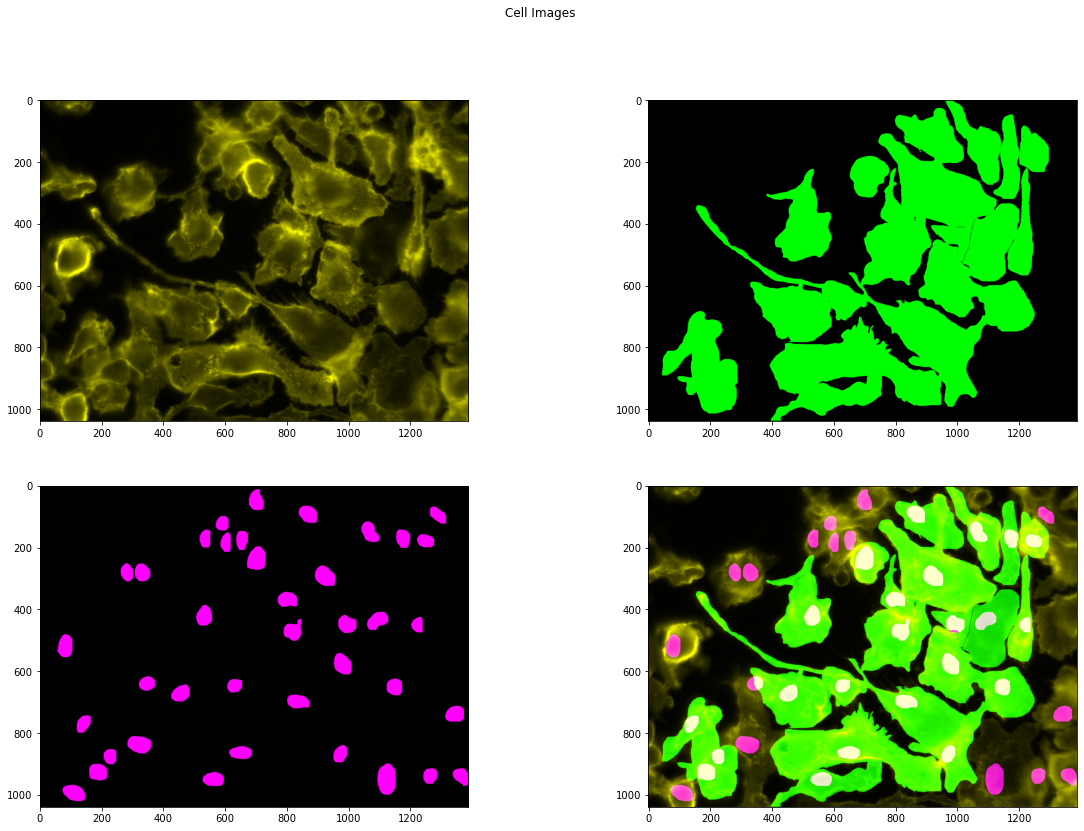

In [21]:
cells[cell_name].display_cell_images()

In [22]:
def run_method(cells: dict, method: Callable, method_name: str = "unknown"):
    for cell_name in cells.keys():
        cells[cell_name].run_method(method, method_name=method_name)

# Threshold Methods

Histogram plot to help choose sensible threshold:

<AxesSubplot:ylabel='Count'>

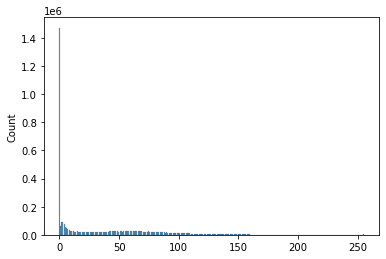

In [23]:
sns.histplot()
cell_pixel_list = cells[cell_name].cell_img.reshape(-1).tolist()
sns.histplot(cell_pixel_list)

In [24]:
def binary_threshold_method(
    cell_img: np.ndarray, threshold_value: int = 55
) -> np.ndarray:
    cell_img = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    _, segmented_img = cv2.threshold(cell_img, threshold_value, 255, cv2.THRESH_BINARY)
    return segmented_img


def otsu_threshold_method(
    cell_img: np.ndarray, threshold_value: int = 55
) -> np.ndarray:
    cell_img = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    _, segmented_img = cv2.threshold(cell_img, threshold_value, 255, cv2.THRESH_OTSU)
    return segmented_img


def gaussian_otsu_threshold_method(cell_img: np.ndarray) -> np.ndarray:
    cell_img = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    cell_img = cv2.GaussianBlur(cell_img, (50, 50), 0)
    _, segmented_img = cv2.threshold(
        cell_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    return segmented_img


def adaptive_threshold_method(cell_img: np.ndarray) -> np.ndarray:
    cell_img = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    segmented_img = cv2.adaptiveThreshold(
        cell_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2
    )
    return segmented_img

In [25]:
run_method(cells, binary_threshold_method, method_name="binary_threshold")
run_method(cells, otsu_threshold_method, method_name="otsu_threshold")
run_method(cells, otsu_threshold_method, method_name="gaussian_otsu_threshold")
run_method(cells, adaptive_threshold_method, method_name="adaptive_threshold")

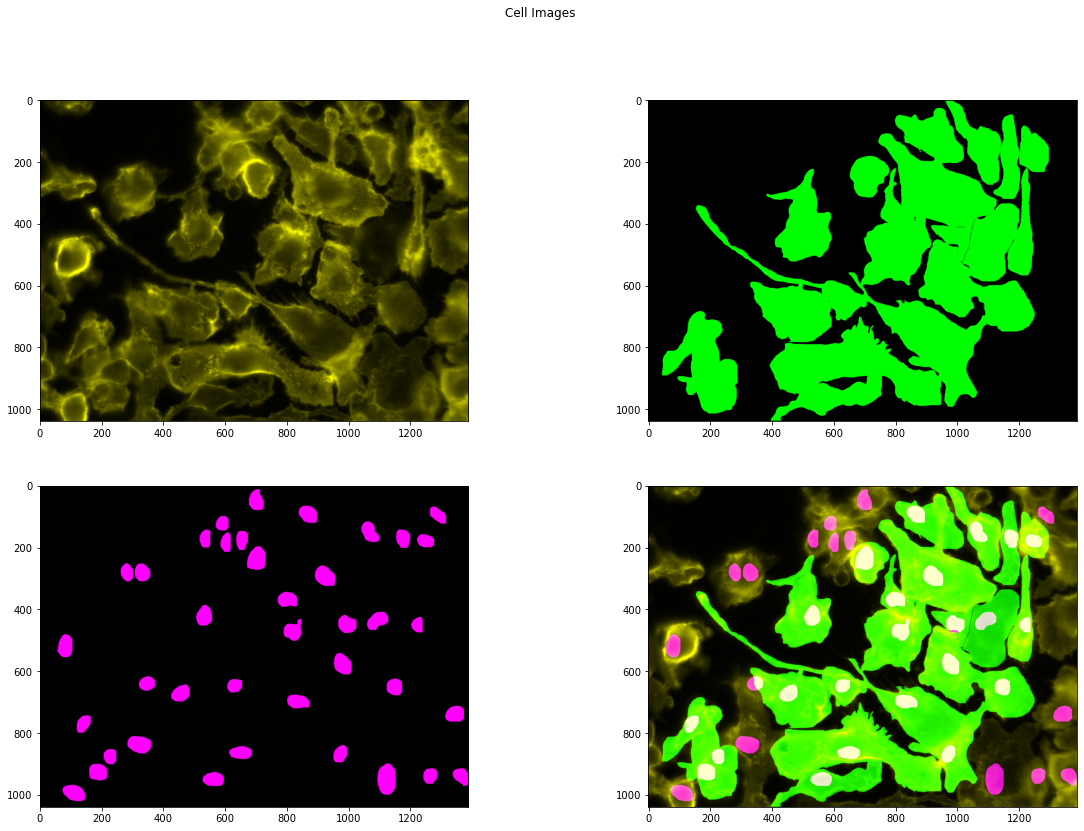

In [26]:
cells[cell_name].display_cell_images()

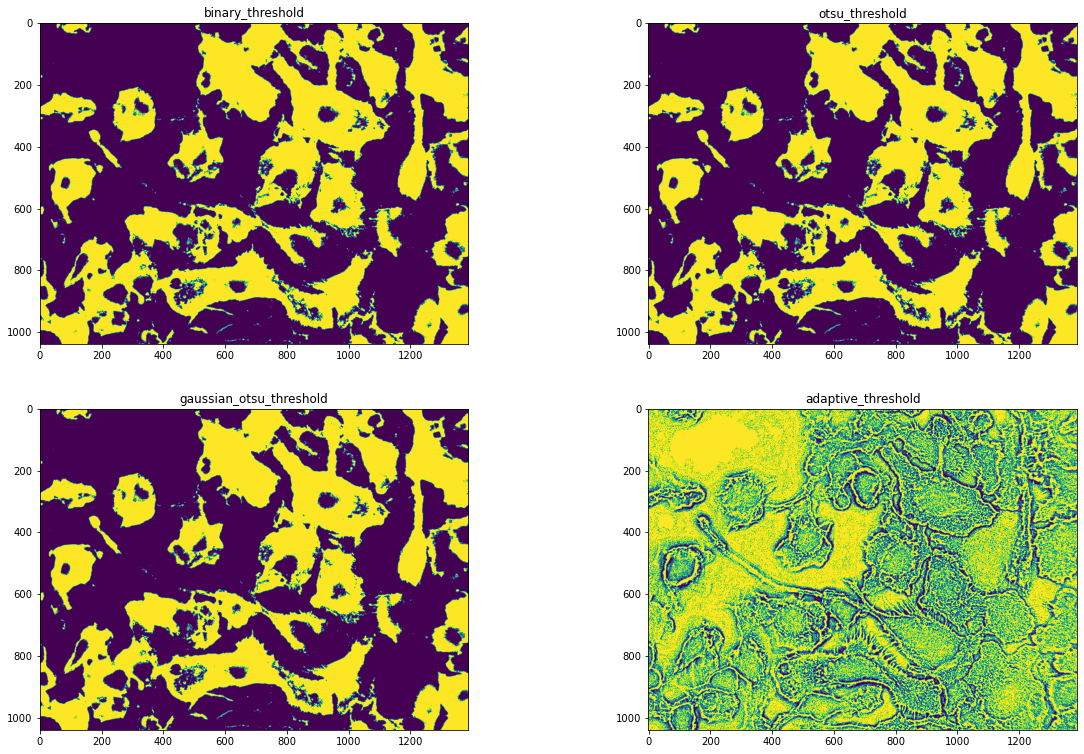

In [27]:
cells[cell_name].display_segmented_images()

## Evaluation

In [28]:
sum_eval_metrics = {}
num_eval_imgs = 0
for cell_name in cells.keys():
    eval_metrics = cells[cell_name].evaluate_segmentations()
    if type(eval_metrics) is not type(None):
        num_eval_imgs += 1
        for method_name in eval_metrics.keys():
            eval_metrics_iou = eval_metrics[method_name]["iou"]
            try:
                sum_eval_metrics[method_name + "_iou"] += eval_metrics[method_name][
                    "iou"
                ]
            except KeyError:
                sum_eval_metrics[method_name + "_iou"] = eval_metrics[method_name][
                    "iou"
                ]

avg_eval_metrics = {key: (val / num_eval_imgs) for key, val in sum_eval_metrics.items()}
print(avg_eval_metrics)

Unable to load gt mask at path: data/BBC020_v1_outlines_nuclei/jw-15min 5_c5_43.TIF
No Cell Mask: jw-30min 1
No Cell Mask: jw-30min 5
No Cell Mask: jw-30min 2
No Cell Mask: jw-30min 3
No Cell Mask: jw-30min 4
{'binary_threshold_iou': 0.423491142456314, 'otsu_threshold_iou': 0.4438552247916577, 'gaussian_otsu_threshold_iou': 0.4438552247916577, 'adaptive_threshold_iou': 0.2913450418258585}
